<a href="https://colab.research.google.com/github/shaheriar/CS-228-Deep-Learning-Project/blob/Experimental-Changes/CS228FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 228 Final Project
## Enhancing Image Captioning with Deep Learning Models
### Saul Gonzalez - sgonz081
### Shaheriar Malik - smali032

Dataset: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

Image captioning is a difficult task that is one step above image classification since we are
generating an actual text description of each image. So, deep learning would be an obvious choice in this case since generating text for a variable input image is a difficult task that would require a complex model.


In [1]:
# PLEASE UNCOMMENT THIS LINE TO INSTALL THE REQUIRED PACKAGES
# ALTERANTIVELY, YOU CAN GO INTO REQUIREMENTS.TXT AND INSTALL THE PACKAGES MANUALLY

# PLEASE CONTACT US AT smali032@ucr.edu OR sgonz081@ucr.edu IF YOU HAVE ANY ISSUES. THANK YOU!

#!pip install -r requirements.txt

In [2]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split, SubsetRandomSampler
from torchtext.data.metrics import bleu_score

from copy import deepcopy
from collections import Counter
from multiprocessing import Pool, cpu_count

from PIL import Image
import nltk

from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from nltk.translate.meteor_score import meteor_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
import csv
import random
import os
import cv2
from collections import Counter, OrderedDict

from textwrap import wrap
from IPython.display import clear_output

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Shaheriar
[nltk_data]     Malik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Dataset Construction and Preprocessing

In [3]:
# Unzips dataset and stores the result at desired location
def unzipDataSet(path_to_zip_file,directory_to_extract_to):
  with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
      zip_ref.extractall(directory_to_extract_to)

In [4]:
# User interface for unziping function
#zip_file_path = 'flickr30k.zip'
storage_directory = ''
#unzipDataSet(zip_file_path,storage_directory)

In [5]:
# Build vocabulary for captions
def build_vocab(captions,tokenizer):
  lens = []
  counter = Counter()
  for caption in captions:
    sentence = caption.strip()
    tokens = tokenizer(sentence)
    lens.append(len(tokens))
    counter.update(tokens)
  sorted_by_freq = sorted(counter.items(), key=lambda x: x[1], reverse=True)
  dictionary = OrderedDict(sorted_by_freq)
  dictionary = dict(dictionary)
  dictionary = OrderedDict(dictionary)
  return vocab(dictionary,specials=['<PAD>','<SOS>','<EOS>','<UNK>']), lens

In [6]:
# Custom dataset class we constructed
class CustomDataset(Dataset):
    def __init__(self, data_dir, label_csv, transform=None):
        self.data_dir = data_dir

        self.data_df = pd.read_csv(label_csv, sep='|',header=None)
        self.data_df = self.data_df.dropna()
        self.captions = self.data_df[1] # 0 is image_name, 1 is comment
        self.captions = self.captions.apply(lambda x: x.lower())
        self.captions = self.captions.apply(lambda x: x.replace("[^A-Za-z]",""))
        self.captions = self.captions.apply(lambda x: x.replace("\s+"," "))
        self.captions = self.captions.apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))

        self.transform = transform
        self.image_paths = self.data_df[0] # Assumes images are directly under data_dir

        self.tokenizer = get_tokenizer("basic_english")
        self.vocab, self.caption_lens = build_vocab(self.captions.tolist(),self.tokenizer)
        self.vocab.set_default_index(self.vocab['<UNK>'])

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_paths[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        caption = self.captions[idx]
        
        if self.transform is not None:
            image = self.transform(image)

        # Vectorize the given caption using our dataset's vocabulary
        caption = caption.strip()
        caption = self.tokenizer(caption)
        caption_vector = [self.vocab['<SOS>']]
        caption_vector.extend([self.vocab[word] for word in caption])
        caption_vector.append(self.vocab['<EOS>'])

        # Return the processed image and any associated labels
        return image, torch.tensor(caption_vector)

In [7]:
# Load in preprocessing steps used in training the WideResNet50
weights = models.Wide_ResNet50_2_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

# Construct custom dataset
data_dir = storage_directory + 'flickr30k/flickr30k_images/'
label_csv = storage_directory + 'flickr30k/results.csv'
dataset = CustomDataset(data_dir, label_csv, transform=preprocess)

In [8]:
test,train = random_split(dataset, [int(len(dataset)*0.3)+1, int(len(dataset)*0.7)])

## Encoder & Decoder

In [9]:
# Checkpoint function used to save model's state dict
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

In [10]:
# Resume function to pickup training process where it left off
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

In [11]:
# Encoder class
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    # Load the pretrained WideResNet-50 model
    initial_resnet = models.wide_resnet50_2(weights=weights)
    # Discard the average pooling and fc at the end of the model
    modules = list(initial_resnet.children())
    necessary_modules = modules[:-2]
    self.resnet = nn.Sequential(*necessary_modules)

  def forward(self,images):
    features = self.resnet(images)
    batch,feature_map,dim1,dim2 = features.size()
    features = features.permute(0, 2, 3, 1)
    # Flatten out dimensions of the encoder's output in order to feed it to the decoder
    features = features.view(batch, dim1*dim2, feature_map)
    return features

In [12]:
# Soft Attention mechanism as described in the following paper: https://arxiv.org/abs/1409.0473
class SoftAttention(nn.Module):
  def __init__(self, encoder_dim, hidden_dim):
    super(SoftAttention, self).__init__()
    self.encoder_attention = nn.Linear(encoder_dim, hidden_dim)
    self.decoder_attention = nn.Linear(hidden_dim, hidden_dim)
    self.attention = nn.Linear(hidden_dim, 1)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, encoder_out, decoder_hidden):
    decoder_hidden = decoder_hidden.unsqueeze(1)
    encoder_att = self.encoder_attention(encoder_out)
    decoder_att = self.decoder_attention(decoder_hidden)
    tanh_att = torch.tanh(encoder_att+decoder_att)

    att = self.attention(tanh_att)
    alpha = self.softmax(att)
    attention_weighted_encoding = (encoder_out * alpha).sum(dim=1)
    alpha = alpha.squeeze(2)

    return attention_weighted_encoding, alpha

In [13]:
# LSTM Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_dim, embed_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(Decoder, self).__init__()

        self.encoder_dim = encoder_dim
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = SoftAttention(encoder_dim, hidden_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, hidden_dim, bias=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.init_weights()

    # Random weight initialization
    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def forward(self, encoder_out, captions):
        batch_size = encoder_out.size(0)
        embeddings = self.embedding(captions)
        h, c = self.init_hidden_state(encoder_out)  # initialize hidden state of LSTM cell

        max_cap_length = captions.size()[1]

        predictions = torch.zeros(batch_size, max_cap_length, self.vocab_size).to(captions.device)
        attn_weights = torch.zeros(batch_size, max_cap_length, encoder_out.size()[1]).to(captions.device)


        for t in range(max_cap_length):

            attention_weighted_encoding, alpha = self.attention(encoder_out, h)

            gate = self.dropout(attention_weighted_encoding)
            concat_input = torch.cat([embeddings[:, t, :], gate], dim=1)
            h, c = self.decode_step(concat_input, (h, c))

            preds = self.fc(self.dropout(h))
            predictions[:, t, :] = preds
            attn_weights[:, t, :] = alpha

        return predictions, attn_weights
        
    # Initialization for h_0 and c_0 using the attention layers
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.attention.encoder_attention(mean_encoder_out)
        c = self.attention.encoder_attention(mean_encoder_out)
        return h, c

## Training Loop 

In [14]:
# Different hyperparameters for decoder
embed_size = 256
hidden_size = 512
vocab_size = len(dataset.vocab)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

encoder = Encoder().to(device)
for param in encoder.parameters():
    param.requires_grad = False

decoder = Decoder(hidden_size,embed_size,vocab_size).to(device)

In [15]:
# Records epoch loss history for data collection
def record_epoch_loss(epoch,epoch_history):
  # CCV Headers and Values
  row_labels = ['Epoch','Loss']
  epoch_numbers = [str(i) for i in range(len(epoch_history))]
  csv_values = [[epoch_numbers[i],epoch_history[i]] for i in range(len(epoch_history))]
  filename = storage_directory + f"/Epoch_Loss_So_far_Epoch_{epoch}.csv"

  with open(filename,'w') as f:
    write = csv.writer(f)
    write.writerow(row_labels)
    write.writerows(csv_values)

In [16]:
# retrives the indicies for the randomly selected grouping
def get_indices(target_len,subset):
  idxs = np.where([subset.dataset.caption_lens[subset.indices[i]] == target_len for i in np.arange(len(subset.indices))])[0]
  return idxs

In [17]:
# 10 Epoch training loop
def training():
  batch_size = 37
  criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab['<PAD>'])
  optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)
  num_epochs = 10
  start_epoch = 0
  epoch_loss_history = []
  
  for epoch in range(start_epoch,num_epochs):
    # Encoder is not being trainned, however the decoder is
    encoder.eval()
    decoder.train()
    
    # Create grouping pools for selection during training
    unique_lens = np.unique(train.dataset.caption_lens)
    target_lens = np.random.choice(unique_lens,len(unique_lens),replace=False)
    epoch_loss = 0


    for i in range(len(target_lens)):
      # Indices for train
      tr_idxs = get_indices(target_lens[i],train)
      tr_caption_sampler = SubsetRandomSampler(indices=tr_idxs)

      # Dataloaders
      train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=3, pin_memory=True, sampler=tr_caption_sampler)
      
      j = 0
      for images, captions in train_loader:
          images = images.to(device, dtype=torch.float)
          captions = captions.to(device)
          
          # Forward pass
          features = encoder(images)
          
          outputs, _ = decoder(features, captions[:,:-1])
          # Reshape captions for loss calculation
          targets = captions[:, 1:].reshape(-1)

          # Compute loss
          loss = criterion(outputs.reshape(-1, vocab_size), targets)
          epoch_loss += loss.item()

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          j += 1 

          # Print the loss
          if j % 100 == 0:
            print('Epoch [{}/{}], Data_Loader Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, j, len(train_loader), epoch_loss))
      
      # Delete dataloader to address memory constraints
      del train_loader
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, len(target_lens), epoch_loss))
    
    # Create a checkpoint for training
    checkpoint(encoder, storage_directory + f"/attn_encoder-epoch-{epoch}.pth")
    checkpoint(decoder, storage_directory + f"/attn_decoder-epoch-{epoch}.pth")
    epoch_loss_history.append(epoch_loss)
    record_epoch_loss(epoch,epoch_loss_history)

  return epoch_loss_history

## Performance Evaluation

In [18]:
train_bool = input('Do you want to train the model or load in previously trained model? (yes or no) ')

if train_bool == 'yes':
  # Calls training function and stores epoch_loss
  epoch_loss_history = training()
else:
  # Loads in the trained models from the storage_directory that the user specifies at the beginning of the code
  embed_size = 256
  decoder_size = 512
  hidden_size = 512
  vocab_size = len(dataset.vocab)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  device = torch.device('mps') if torch.backends.mps.is_available() else device

  encoder = Encoder().to(device)
  decoder = Decoder(hidden_size,embed_size,vocab_size).to(device)
  encoder.load_state_dict(torch.load(storage_directory + 'attn_encoder_v2.pth', map_location=torch.device(device)))
  decoder.load_state_dict(torch.load(storage_directory + 'attn_decoder_v2.pth', map_location=torch.device(device)))
  encoder.to(device)
  decoder.to(device)

In [19]:
# Inference function for generating captions using a probability distribution
def inference_function(image):
  encoder.eval()
  decoder.eval()
  features = encoder(image)
  attention_weights_list = []  # List to store attention weights for each word
  attention_encoding_list = []  # List to store attention encoding for each word
  caption = [dataset.vocab['<SOS>']]
  with torch.no_grad():
    while caption[-1] != dataset.vocab['<EOS>'] and len(caption) < 25:
      captions = torch.tensor(caption).unsqueeze(0).to(device)
      outputs, attention_weights  = decoder(features, captions)
      probs = F.log_softmax(outputs,dim=2)
      top_idx = probs[0].topk(1)[1]
      caption.append(top_idx[-1].item())
      attention_weights_list.append(attention_weights.cpu().numpy())
      attention_encoding_list.append(decoder.attention.encoder_attention)
  i = 0
  full_caption = []
  for idx in caption:
    if dataset.vocab.lookup_token(idx) not in ['<PAD>','<SOS>','<EOS>']:
      full_caption.append(dataset.vocab.lookup_token(idx))
      i += 1
  #full_caption = [dataset.vocab.lookup_token(idx) for idx in caption if dataset.vocab.lookup_token(idx) not in ['<PAD','<SOS>','<EOS>']]
  return full_caption, attention_weights_list#, attention_encoding_list

i  BLEU Score                   METEOR Score
0  0.01757079221363             0.17543859649123
1  0.03708765842106             0.32440929878049
2  0.12740810460324             0.28846153846154


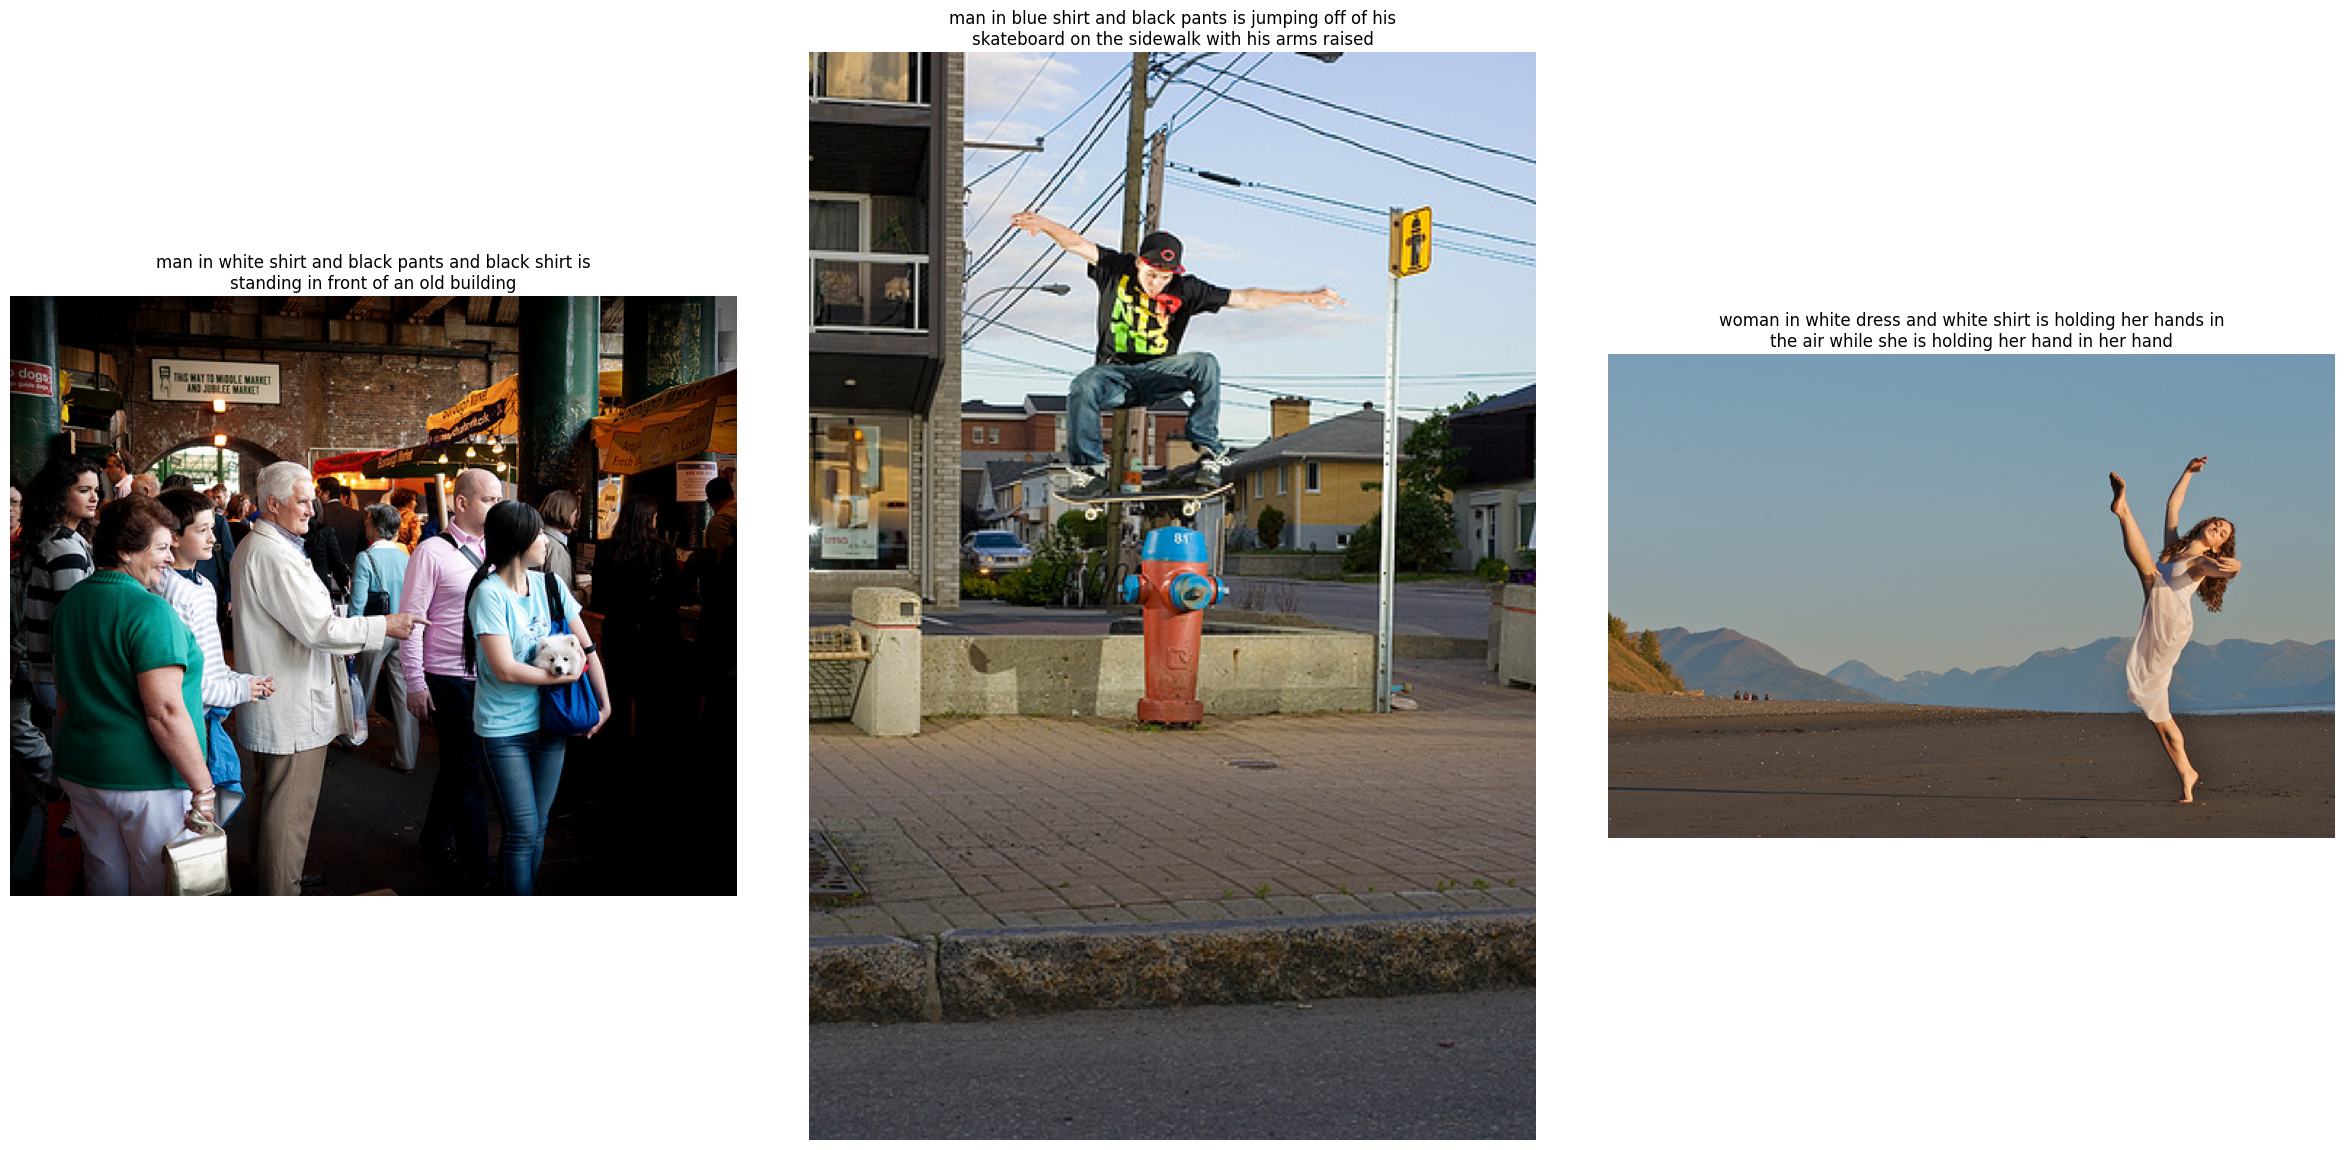

In [23]:
# Picks 3 random images from the entire dataset and creates captions for them
n=0
plt.figure(figsize = (30 , 30))
b = 0
m = 0
print('i  BLEU Score                   METEOR Score')
for i in range(3):
  k = random.randint(0, len(dataset))
  start = k - (k%5)
  end = k + (5 - k%5)
  normal_image_path = os.path.join(dataset.data_dir, dataset.image_paths[k])
  normal_image = cv2.imread(normal_image_path)
  normal_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2RGB)
  image = dataset[k][0].unsqueeze(0)
  image = image.to(device, dtype=torch.float)
  full_caption, weightlist = inference_function(image)
  plt.subplot(1 , 3, i+1)
  plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
  plt.axis('off')
  plt.title("\n".join(wrap(' '.join(full_caption),60)))
  plt.imshow(normal_image,aspect='equal')
  listsplit = list()
  for x in range(start,end):
    listsplit.append(dataset.captions[x].split(' '))
    #print(listsplit)
  cc = SmoothingFunction()
  print('{}  {:<12.14f}             {:<12.14f}'.format(i,sentence_bleu(listsplit,full_caption, smoothing_function=cc.method1), meteor_score(listsplit,full_caption)))

In [21]:
# Test validation loop
def testing():
  decoder.eval()
  encoder.eval()
  avg_bleu = 0
  avg_meteor = 0
  x = 0
  test_loader = DataLoader(test, shuffle=False)
  with torch.no_grad():
    for images, captions in test_loader:
      print('step [{},{}]'.format(x,len(test_loader)))
      images = images.to(device, dtype=torch.float)
      for i, image in enumerate(images):
        true_caption = []
        for idx in captions[i]:
          if dataset.vocab.lookup_token(idx) not in ['<PAD>','<SOS>','<EOS>']:
            true_caption.append(dataset.vocab.lookup_token(idx))
        image = image.unsqueeze(0)
        full_caption, weightlist = inference_function(image)
        avg_bleu += sentence_bleu([true_caption],full_caption, smoothing_function=cc.method1)
        avg_meteor += meteor_score([true_caption],full_caption)
      x += 1
  print('Average BLEU:',avg_bleu/len(test_loader))
  print('Average METEOR:',avg_meteor/len(test_loader))

In [22]:
# Asks user if they want to evaulate the model's performance on the test dataset
test_bool = input('Do you want to run the test dataset evaluation? (yes or no) ')
if test_bool == 'yes':
  testing()